In [1]:
% matplotlib inline
% load_ext autoreload
% autoreload 2

In [2]:
import pandas as pd
import numpy as np
import keras
import sklearn
from sklearn.neural_network import MLPClassifier
import olac

from IPython import display

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [3]:
## -- Use last N points

## -- autencode to 2D

## -- Use as input for 

In [6]:
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.base import BaseEstimator, ClassifierMixin

In [7]:
class EncodingGenerator():
    def __init__(self, layers, n, dim):
        self.history = []
        self.layers = layers
        self.n = n
        self.dim = dim
        self._autoencoder = self._encoder()


    def _encoder(self):
        """
        Encode the input points
        
        Parameters
        ----------
        points: array
            Array of points to encode, shape of inputlayer.
        """
        
        self._input_layer = Input(shape = (int(self.n*self.dim),))
        self._encoded = Dense(self.layers[0][0], activation=self.layers[0][1])(self._input_layer)
        for layer in self.layers[1:]:
            self._encoded = Dense(layer[0], activation=layer[1])(self._encoded)

        self._decoded = Dense(self.layers[-2][0], activation=self.layers[-2][1])(self._encoded)
        for layer in self.layers[::-1][1:]:
            self._decoded = Dense(layer[0], activation=layer[1])(self._decoded)
        self._decoded = Dense(int(self.n*self.dim), activation='relu')(self._decoded)

        autoencoder = Model(self._input_layer, self._decoded)
        autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

        return autoencoder

    def encode(self, points):
#         hist = np.vstack(self.history)[:,:-1]
        self._autoencoder.fit(points, points, verbose=False, epochs=10)
#         self._autoencoder.train_on_batch(points, points)
        self._encoder_model = Model(self._input_layer, self._encoded)
        
        return self._encoder_model.predict(points)

    
    def __call__(self, data):
        for point in data:
            self.history.append(point)
            if len(self.history) > self.n:
                last_n = np.vstack(self.history[-self.n:])
                X = last_n[:,:-1].reshape(1, int(self.n*self.dim))
                y = last_n[-1,-1]
                yield np.hstack([self.encode(X)[0], y])
            
            

KeyboardInterrupt: 

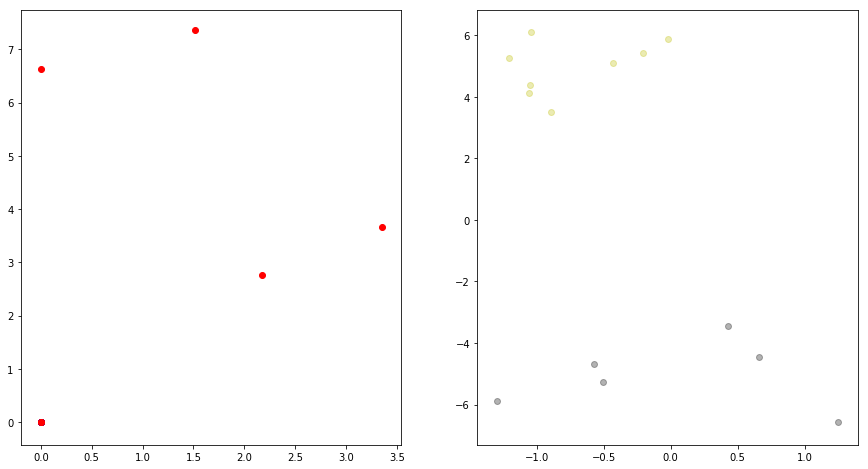

In [8]:
plt.figure(figsize=(15,8))
encoder = EncodingGenerator([(32, 'relu'), (8, 'relu'), (2, 'relu')], n=30, dim=2)
datastream = encoder(olac.data_generators.roving_balls())
i=0
for p in datastream:
    plt.subplot(121)
    plt.scatter(*p[:2].T, c= ['r','b'][int(p[-1])])
    
    plt.subplot(122)
    p2 = encoder.history[i]
    plt.scatter(*p2[:2].T, c= ['y','k'][int(p2[-1])], alpha=.3)
    i+=1
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [10]:
df = pd.read_csv('../data/raw/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [11]:
n_points = 5000
imb_contam = 0.1  # contamination fraction

n_points_0 = int(np.round((1-imb_contam)*n_points))
n_points_1 = int(np.round(imb_contam*n_points))

X_df = df[['Amount'] + [f'V{i+1}' for i in range(28)]]
y = df['Class']

# choose the indices
df_inds_0 = np.random.choice(y[y==0].index, size=(n_points_0,))
df_inds_1 = np.random.choice(
    y[y==1].index, 
    size=(n_points_1,), 
    replace=(n_points_1 > y.sum())
)
df_inds = np.hstack([df_inds_0, df_inds_1]) 
np.random.shuffle(df_inds)

# set up the array
cc = np.array(list(olac.data_generators.dynamify_data(
    X_df.iloc[df_inds], 
    y.iloc[df_inds], 
    transition_rate=0.001, 
)))

In [58]:
df_col = df.columns.values
# list(df_col[1:-1])

KeyboardInterrupt: 

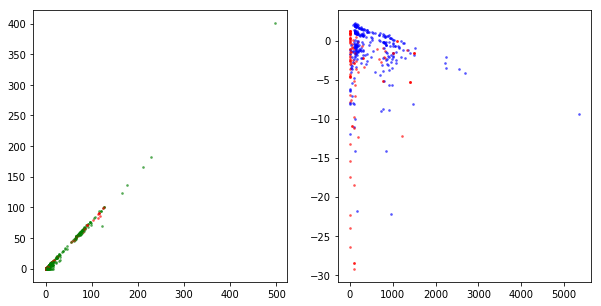

In [83]:
plt.figure(figsize=(10,5))
encoder = EncodingGenerator([(32, 'relu'), (8, 'relu'), (2, 'relu')], n=1, dim=29)
# datastream = encoder(olac.data_generators.generator_from_csv('../data/raw/creditcard.csv',
#                                                              list(df_col[1:-1]), label_column=df_col[-1]))
datastream = encoder(cc)
i=0
for p in datastream:
    plt.subplot(121)
    plt.scatter(*p[:2].T, c= ['g','r'][int(p[-1])], alpha=.5, s=3)
    
    plt.subplot(122)
    p2 = encoder.history[i]
    plt.scatter(*p2[:2].T, c= ['b','r'][int(p2[-1])], alpha=.5, s=3)
    i+=1
    display.display(plt.gcf())
    display.clear_output(wait=True)

## Test the pipeline

In [26]:
# -- using the roving balls dataset generator
# data_generator = olac.data_generators.roving_balls(steps=4000, radius=1)

encoder = EncodingGenerator([(32, 'relu'), (8, 'relu'), (2, 'relu')], n=10, dim=2)
# datastream = list(encoder(cc))
datastream = list(encoder(olac.data_generators.roving_balls(steps=50)))

# -- using the multilayer perceptron classifier from sklearn
model = MLPClassifier((63,32,))
# -- using the online predictor algorithm
predictor = olac.pipeline.OnlinePredictor(verbose=True)
# -- using a simple threshold labeller
labeller = olac.pipeline.ThresholdLabeller(threshold=20, prob=0.8, verbose=True)

# -- Define the pipeline using the above defined elements
pipeline = olac.pipeline.Pipeline(data_generator=datastream, 
                                  model=model,
                                  predictor=predictor,
                                  labeller=labeller)


In [27]:
eval_set, train_set = pipeline.run()

Labeller:	Threshold met, 41 new points available in queue
Labeller:	Labelled 30 new points


In [28]:
eval_set

In [29]:
train_set